# High-Frequency Grid Trading - Comparison Across Other Exchanges

So far, we have explored examples in Binance Futures. In this section, we demonstrate how results can vary for the same pair and parameter set across different exchanges, due to differences in order flow.

Since each exchange may have its own distinct order flow, performance can differ significantly. This also highlights the need to explore alternative parameter sets to optimize performance for each specific exchange. By doing so, you can extend your analysis to other platforms such as OKX, Hyperliquid, and more.

In [1]:
import json
import datetime
import itertools

from multiprocessing import Pool

import polars as pl

import numpy as np

from numba import njit, uint64, float64
from numba.typed import Dict

from matplotlib import pyplot as plt

from hftbacktest import BUY, SELL, GTX, LIMIT, BUY_EVENT, SELL_EVENT
from hftbacktest import BacktestAsset, ROIVectorMarketDepthBacktest, Recorder
from hftbacktest.stats import LinearAssetRecord

@njit
def gridtrading(hbt, recorder, relative_half_spread, relative_grid_interval, min_grid_step, grid_num, skew, order_qty):
    asset_no = 0
    tick_size = hbt.depth(asset_no).tick_size
    max_position = grid_num * order_qty
        
    # Running interval in nanoseconds.
    while hbt.elapse(100_000_000) == 0:
        # Clears cancelled, filled or expired orders.        
        hbt.clear_inactive_orders(asset_no)

        depth = hbt.depth(asset_no)
        position = hbt.position(asset_no)
        orders = hbt.orders(asset_no)

        best_bid = depth.best_bid
        best_ask = depth.best_ask
        
        mid_price = (best_bid + best_ask) / 2.0

        normalized_position = position / order_qty

        relative_bid_depth = relative_half_spread + skew * normalized_position
        relative_ask_depth = relative_half_spread - skew * normalized_position

        # Please see Market Making with Alpha example series.
        # https://hftbacktest.readthedocs.io/en/latest/tutorials/Market%20Making%20with%20Alpha%20-%20Order%20Book%20Imbalance.html
        # https://hftbacktest.readthedocs.io/en/latest/tutorials/Market%20Making%20with%20Alpha%20-%20Basis.html
        # https://hftbacktest.readthedocs.io/en/latest/tutorials/Market%20Making%20with%20Alpha%20-%20APT.html
        #
        # Without alpha, this relies heavily on rebates combined with short-term mean reversion to the current price — 
        # a behavior that has been observed to be particularly strong in altcoins.
        alpha = 0.0
        forecast_mid_price = mid_price + alpha

        # Since our price is skewed, it may cross the spread. To ensure market making and avoid crossing the spread, 
        # limit the price to the best bid and best ask.
        bid_price = np.minimum(forecast_mid_price * (1.0 - relative_bid_depth), best_bid)
        ask_price = np.maximum(forecast_mid_price * (1.0 + relative_ask_depth), best_ask)

        # min_grid_step enforces grid interval changes to be no less than min_grid_step, which
        # stabilizes the grid_interval and keeps the orders on the grid more stable.
        grid_interval = max(np.round(forecast_mid_price * relative_grid_interval / min_grid_step) * min_grid_step, min_grid_step)

        # Aligns the prices to the grid.
        bid_price = np.floor(bid_price / grid_interval) * grid_interval
        ask_price = np.ceil(ask_price / grid_interval) * grid_interval
        
        #--------------------------------------------------------
        # Updates quotes.
        
        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.uint64, np.float64)
        if position < max_position and np.isfinite(bid_price): # position * mid_price < max_notional_position
            for i in range(grid_num):
                bid_price_tick = round(bid_price / tick_size)
                
                # order price in tick is used as order id.
                new_bid_orders[uint64(bid_price_tick)] = bid_price
                
                bid_price -= grid_interval

        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.uint64, np.float64)
        if position > -max_position and np.isfinite(ask_price): # position * mid_price > -max_notional_position
            for i in range(grid_num):
                ask_price_tick = round(ask_price / tick_size)
                
                # order price in tick is used as order id.
                new_ask_orders[uint64(ask_price_tick)] = ask_price

                ask_price += grid_interval
                
        order_values = orders.values();
        while order_values.has_next():
            order = order_values.get()
            # Cancels if a working order is not in the new grid.
            if order.cancellable:
                if (
                    (order.side == BUY and order.order_id not in new_bid_orders)
                    or (order.side == SELL and order.order_id not in new_ask_orders)
                ):
                    hbt.cancel(asset_no, order.order_id, False)
                    
        for order_id, order_price in new_bid_orders.items():
            # Posts a new buy order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_buy_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
                
        for order_id, order_price in new_ask_orders.items():
            # Posts a new sell order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_sell_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
        
        # Records the current state for stat calculation.
        recorder.record(hbt)
    return True

## Binance Futures

<div class="alert alert-info">
    
**Note:** This example is for educational purposes only and demonstrates effective strategies for high-frequency market-making schemes. All backtests are based on a 0.005% rebate, the highest market maker rebate available on Binance Futures. See <a href="https://www.binance.com/en/support/announcement/binance-updates-usd%E2%93%A2-margined-futures-liquidity-provider-program-2024-06-03-fefc6aa25e0947e2bf745c1c56bea13e">Binance Upgrades USDⓢ-Margined Futures Liquidity Provider Program</a> for more details.
    
</div>

In [3]:
dates = []
date = datetime.datetime(2025, 4, 1)
until = datetime.datetime(2025, 5, 19)
while date <= until:
    dates.append(date.strftime("%Y%m%d"))
    date += datetime.timedelta(days=1)

latency_data = np.concatenate(
    [np.load('binance_latency/order_latency_{}.npz'.format(date))['data'] for date in dates]
)
    
def backtest(args):
    asset_name, asset_info, half_spread = args

    # Obtains the mid-price of the assset to determine the order quantity.
    snapshot = np.load('binance_data/{}/{}_20250331_eod.npz'.format(asset_name, asset_name))['data']
    best_bid = max(snapshot[snapshot['ev'] & BUY_EVENT == BUY_EVENT]['px'])
    best_ask = min(snapshot[snapshot['ev'] & SELL_EVENT == SELL_EVENT]['px'])
    mid_price = (best_bid + best_ask) / 2.0

    data = ['binance_data/{}/{}_{}.npz'.format(asset_name, asset_name, date) for date in dates]
    
    asset = (
        BacktestAsset()
            .data(data)
            .initial_snapshot('binance_data/{}/{}_20250331_eod.npz'.format(asset_name, asset_name))
            .linear_asset(1.0) 
            .intp_order_latency(latency_data)
            .power_prob_queue_model3(3.0) 
            .no_partial_fill_exchange()
            .trading_value_fee_model(-0.00005, 0.0007)
            .tick_size(asset_info['tick_size'])
            .lot_size(asset_info['lot_size'])
            .roi_lb(0)
            .roi_ub(mid_price * 5)
    )
    hbt = ROIVectorMarketDepthBacktest([asset])

    # Sets the order quantity to be equivalent to a notional value of $100.
    order_qty = max(round((100 / mid_price) / asset_info['lot_size']), 1) * asset_info['lot_size']

    grid_num = 20
    grid_interval = half_spread
    skew = half_spread / grid_num
    min_grid_step = asset_info['tick_size']
    
    recorder = Recorder(1, 50_000_000)

    gridtrading(hbt, recorder.recorder, half_spread, grid_interval, min_grid_step, grid_num, skew, order_qty)

    hbt.close()

    recorder.to_npz('binance_stats/gridtrading_{}_{}.npz'.format(asset_name, half_spread))

In [4]:
%%capture

with open('binance_assets.json', 'r') as f:
    assets =  json.load(f)

args = list(itertools.product(list(assets.items()), [0.0005, 0.0010, 0.0015]))
args = [(*tup, x) for tup, x in args]
    
with Pool(16) as p:
    print(p.map(backtest, args))

As we have demonstrated so far, the strategy collectively produces a favorable equity curve when factoring in rebates.

In [6]:
equity_values = {}
half_spread = 0.001
for asset_name, _ in assets.items():
    data = np.load('binance_stats/gridtrading_{}_{}.npz'.format(asset_name, half_spread))['0']
    stats = (
        LinearAssetRecord(data)
            .resample('5m')
            .stats()
    )

    equity = stats.entire.with_columns(
        (pl.col('equity_wo_fee') - pl.col('fee')).alias('equity')
    ).select(['timestamp', 'equity'])
    equity_values[asset_name] = equity

Text(0, 0.5, 'Cumulative Returns (%)')

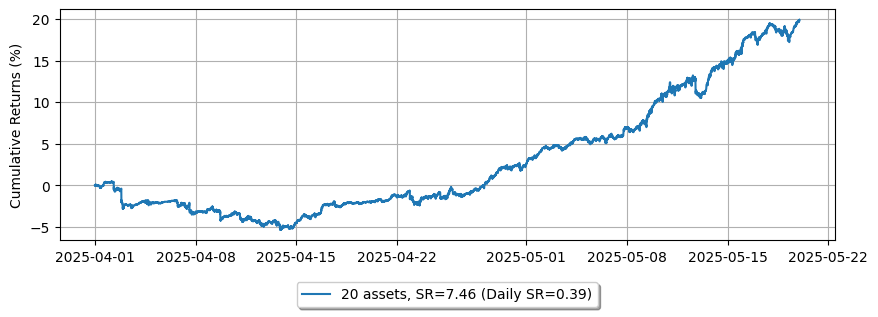

In [7]:
fig = plt.figure()
fig.set_size_inches(10, 3)

legend = []
net_equity = None
for i, equity in enumerate(list(equity_values.values())):
    asset_number = i + 1
    if net_equity is None:
        net_equity = equity['equity'].clone()
    else:
        net_equity += equity['equity'].clone()

# 2_000 is capital for each trading asset.
net_equity_df = pl.DataFrame({
    'cum_ret': (net_equity / asset_number) / 2_000 * 100,
    'timestamp': equity['timestamp']
})
net_equity_rs_df = net_equity_df.group_by_dynamic(
    index_column='timestamp',
    every='1d'
).agg([
    pl.col('cum_ret').last()
])
pnl = net_equity_rs_df['cum_ret'].diff()
sr = pnl.mean() / pnl.std()
ann_sr = sr * np.sqrt(365)

plt.plot(net_equity_df['timestamp'], net_equity_df['cum_ret'])
legend.append('{} assets, SR={:.2f} (Daily SR={:.2f})'.format(asset_number, ann_sr, sr))

plt.legend(
    legend,
    loc='upper center', bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=3
)

plt.grid()
plt.ylabel('Cumulative Returns (%)')

In addition, this is for demonstration purpose to use the single parameter set, but you can find more optimum parameter set for each pair, which also have a risk to lead to the overfitting.

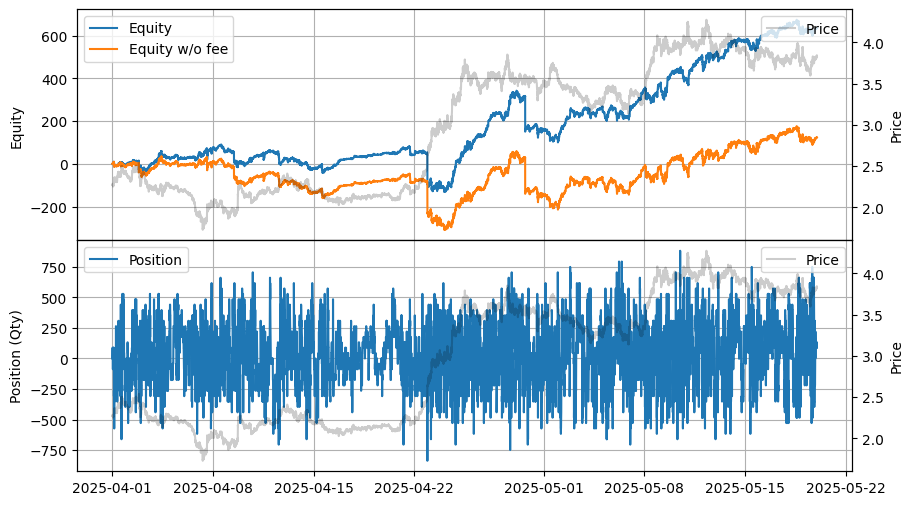

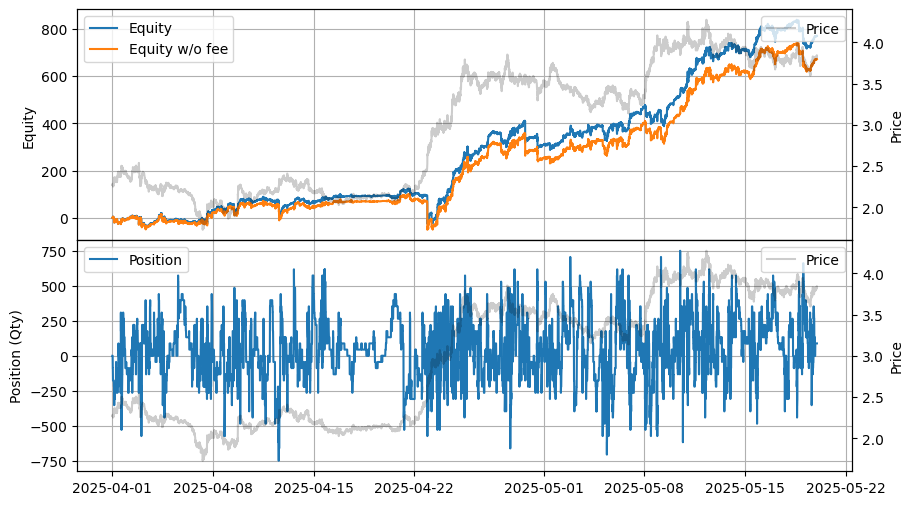

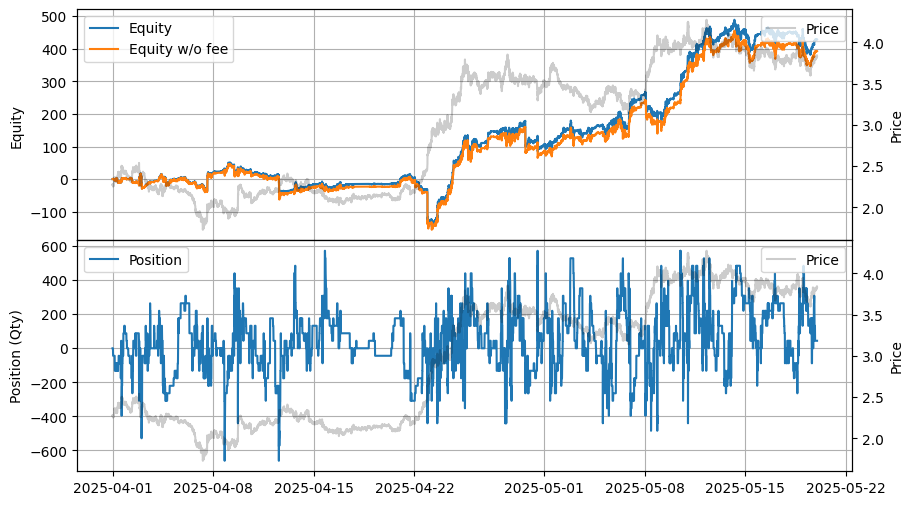

In [9]:
for half_spread in [0.0005, 0.001, 0.0015]:
    data = np.load('binance_stats/gridtrading_SUIUSDT_{}.npz'.format(half_spread))['0']
    stats = (
        LinearAssetRecord(data)
            .resample('5m')
            .stats()
    )
    stats.plot()

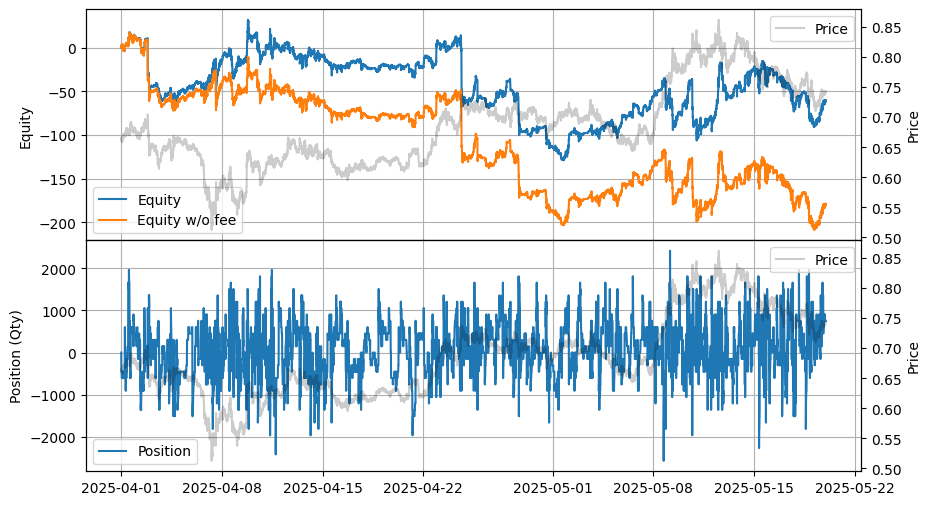

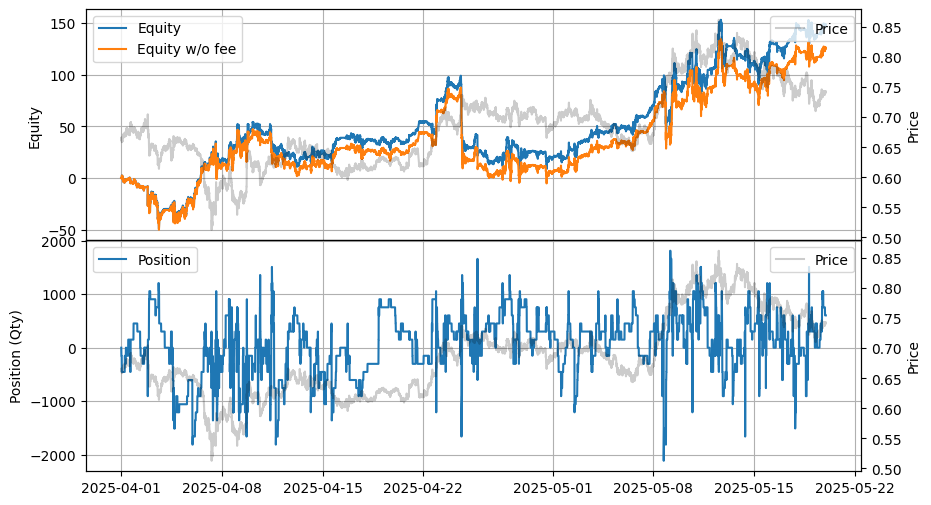

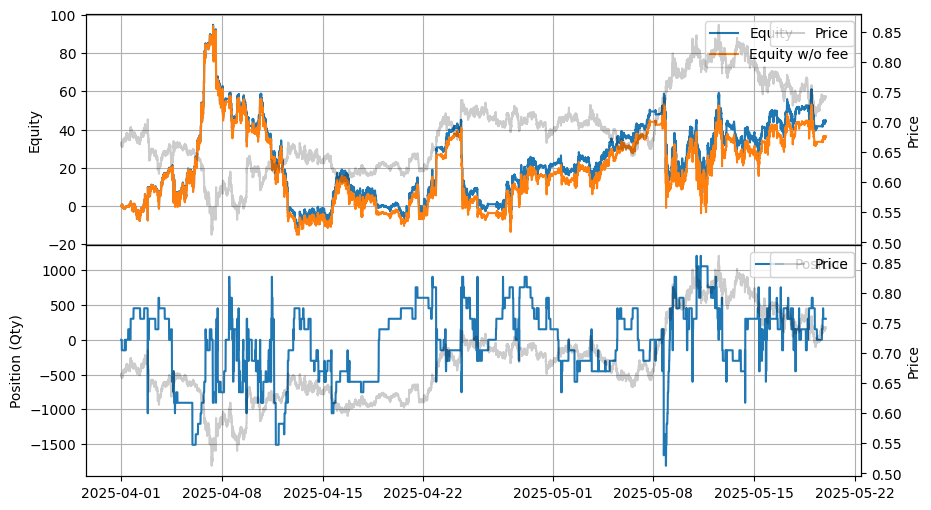

In [10]:
for half_spread in [0.0005, 0.001, 0.0015]:
    data = np.load('binance_stats/gridtrading_ADAUSDT_{}.npz'.format(half_spread))['0']
    stats = (
        LinearAssetRecord(data)
            .resample('5m')
            .stats()
    )
    stats.plot()

## Bybit

<div class="alert alert-info">
    
**Note:** This example is for educational purposes only and demonstrates effective strategies for high-frequency market-making schemes. All backtests are based on a 0.0025% rebate, the market maker rebate available on Bybit Futures. See <a href="https://www.bybit.com/en/help-center/article/Introduction-to-the-Market-Maker-Incentive-Program">Introduction to the Market Maker Incentive Program</a> for more details.
    
</div>

In [12]:
latency_data = np.concatenate(
    [np.load('bybit_latency/order_latency_{}.npz'.format(date))['data'] for date in dates]
)
    
def backtest(args):
    asset_name, asset_info, half_spread = args

    # Obtains the mid-price of the assset to determine the order quantity.
    snapshot = np.load('bybit_data/{}/{}_20250331_eod.npz'.format(asset_name, asset_name))['data']
    best_bid = max(snapshot[snapshot['ev'] & BUY_EVENT == BUY_EVENT]['px'])
    best_ask = min(snapshot[snapshot['ev'] & SELL_EVENT == SELL_EVENT]['px'])
    mid_price = (best_bid + best_ask) / 2.0

    data = ['bybit_data/{}/{}_{}.npz'.format(asset_name, asset_name, date) for date in dates]
    
    asset = (
        BacktestAsset()
            .data(data)
            # Tardis collects Bybit data from Tokyo, but the Bybit server is located in Singapore.
            # 
            # Therefore, if we assume our strategy will run in Singapore, we need to adjust for the feed latency.
            # The round-trip time (RTT) between Tokyo and Singapore is approximately 70 ms.
            # For our purposes, we subtract 30 ms as the estimated one-way latency from Singapore to Tokyo, including a small buffer.
            #
            # https://docs.tardis.dev/historical-data-details/bybit#market-data-collection-details
            # https://bybit-exchange.github.io/docs/faq#where-are-bybits-servers-located
            # https://elitwilliams.medium.com/geographic-latency-in-crypto-how-to-optimally-co-locate-your-aws-trading-server-to-any-exchange-58965ea173a8
            .latency_offset(-30_000_000)
            .initial_snapshot('bybit_data/{}/{}_20250331_eod.npz'.format(asset_name, asset_name))
            .linear_asset(1.0) 
            .intp_order_latency(latency_data)
            .power_prob_queue_model3(3.0) 
            .no_partial_fill_exchange()
            .trading_value_fee_model(-0.000025, 0.00055)
            .tick_size(asset_info['tick_size'])
            .lot_size(asset_info['lot_size'])
            .roi_lb(0)
            .roi_ub(mid_price * 5)
    )
    hbt = ROIVectorMarketDepthBacktest([asset])

    # Sets the order quantity to be equivalent to a notional value of $100.
    order_qty = max(round((100 / mid_price) / asset_info['lot_size']), 1) * asset_info['lot_size']

    grid_num = 20
    grid_interval = half_spread
    skew = half_spread / grid_num
    min_grid_step = asset_info['tick_size']
    
    recorder = Recorder(1, 50_000_000)

    gridtrading(hbt, recorder.recorder, half_spread, grid_interval, min_grid_step, grid_num, skew, order_qty)

    hbt.close()

    recorder.to_npz('bybit_stats/gridtrading_{}_{}.npz'.format(asset_name, half_spread))

In [13]:
%%capture

with open('bybit_assets.json', 'r') as f:
    assets =  json.load(f)

args = list(itertools.product(list(assets.items()), [0.0005, 0.0010, 0.0015]))
args = [(*tup, x) for tup, x in args]
    
with Pool(16) as p:
    print(p.map(backtest, args))

In [14]:
equity_values = {}
half_spread = 0.001
for asset_name, _ in assets.items():
    data = np.load('bybit_stats/gridtrading_{}_{}.npz'.format(asset_name, half_spread))['0']
    stats = (
        LinearAssetRecord(data)
            .resample('5m')
            .stats()
    )

    equity = stats.entire.with_columns(
        (pl.col('equity_wo_fee') - pl.col('fee')).alias('equity')
    ).select(['timestamp', 'equity'])
    equity_values[asset_name] = equity

Text(0, 0.5, 'Cumulative Returns (%)')

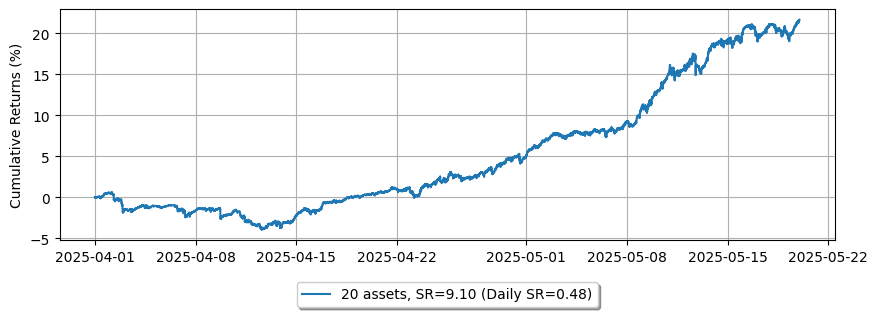

In [15]:
fig = plt.figure()
fig.set_size_inches(10, 3)

legend = []
net_equity = None
for i, equity in enumerate(list(equity_values.values())):
    asset_number = i + 1
    if net_equity is None:
        net_equity = equity['equity'].clone()
    else:
        net_equity += equity['equity'].clone()

# 2_000 is capital for each trading asset.
net_equity_df = pl.DataFrame({
    'cum_ret': (net_equity / asset_number) / 2_000 * 100,
    'timestamp': equity['timestamp']
})
net_equity_rs_df = net_equity_df.group_by_dynamic(
    index_column='timestamp',
    every='1d'
).agg([
    pl.col('cum_ret').last()
])
pnl = net_equity_rs_df['cum_ret'].diff()
sr = pnl.mean() / pnl.std()
ann_sr = sr * np.sqrt(365)

plt.plot(net_equity_df['timestamp'], net_equity_df['cum_ret'])
legend.append('{} assets, SR={:.2f} (Daily SR={:.2f})'.format(asset_number, ann_sr, sr))

plt.legend(
    legend,
    loc='upper center', bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=3
)

plt.grid()
plt.ylabel('Cumulative Returns (%)')

You can observe performance differences across exchanges using the same parameter set.

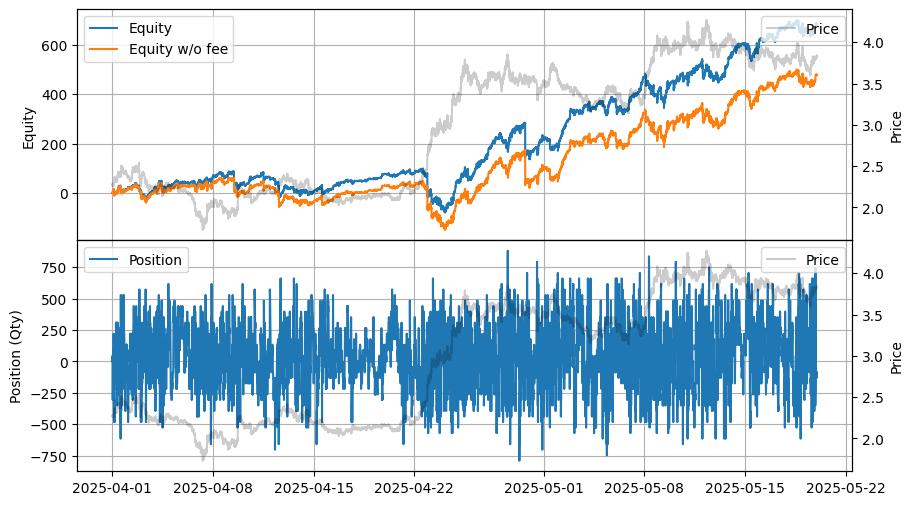

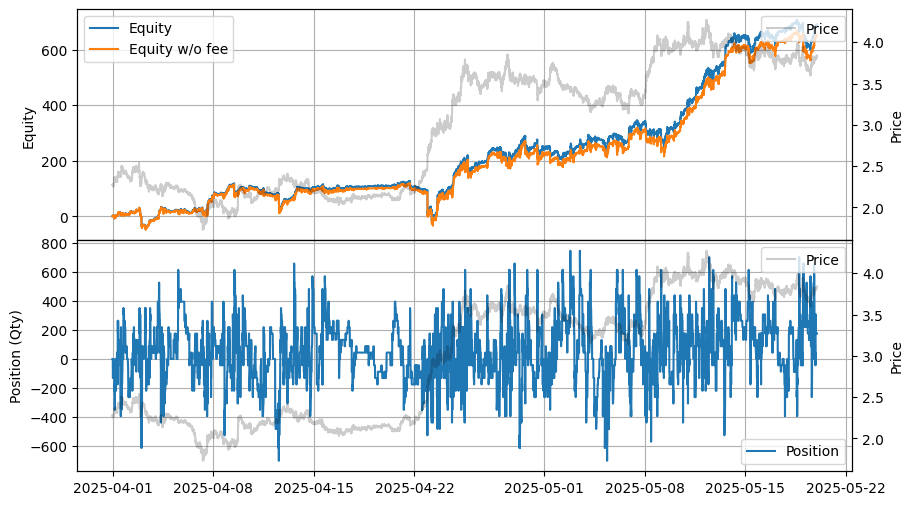

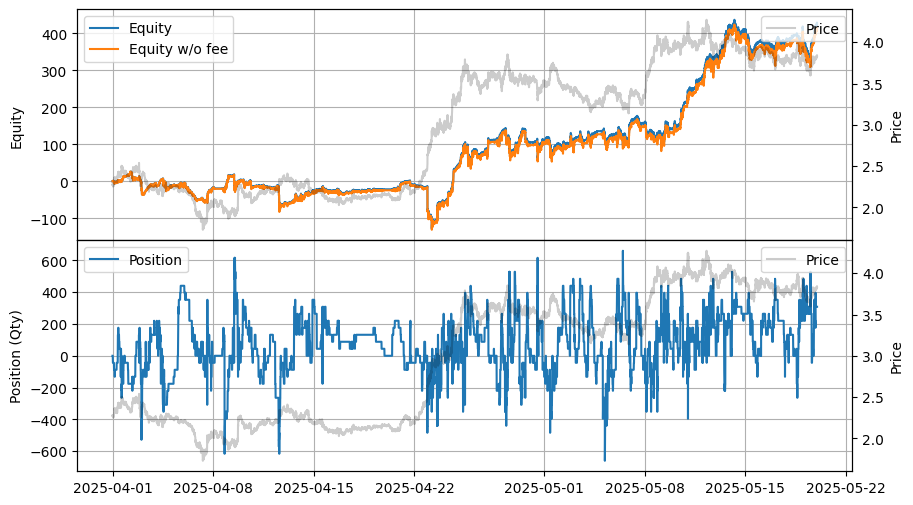

In [17]:
for half_spread in [0.0005, 0.001, 0.0015]:
    data = np.load('bybit_stats/gridtrading_SUIUSDT_{}.npz'.format(half_spread))['0']
    stats = (
        LinearAssetRecord(data)
            .resample('5m')
            .stats()
    )
    stats.plot()

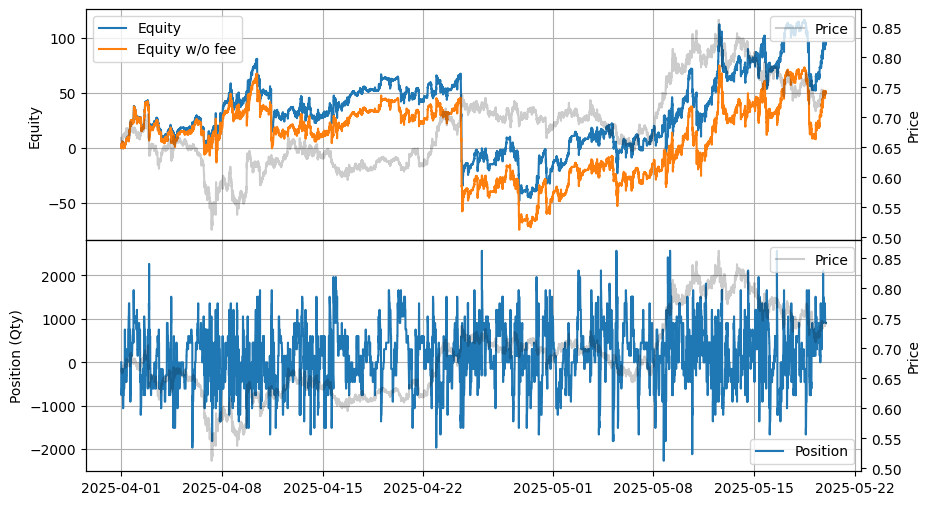

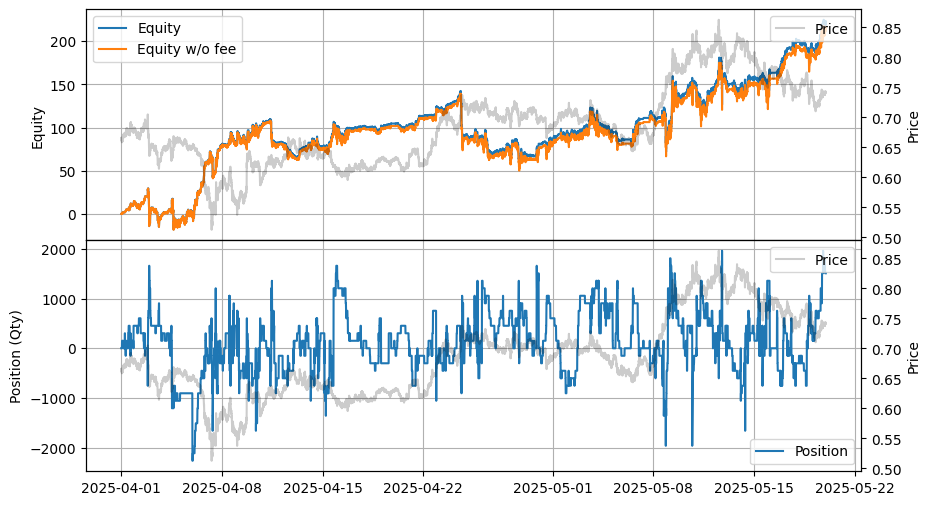

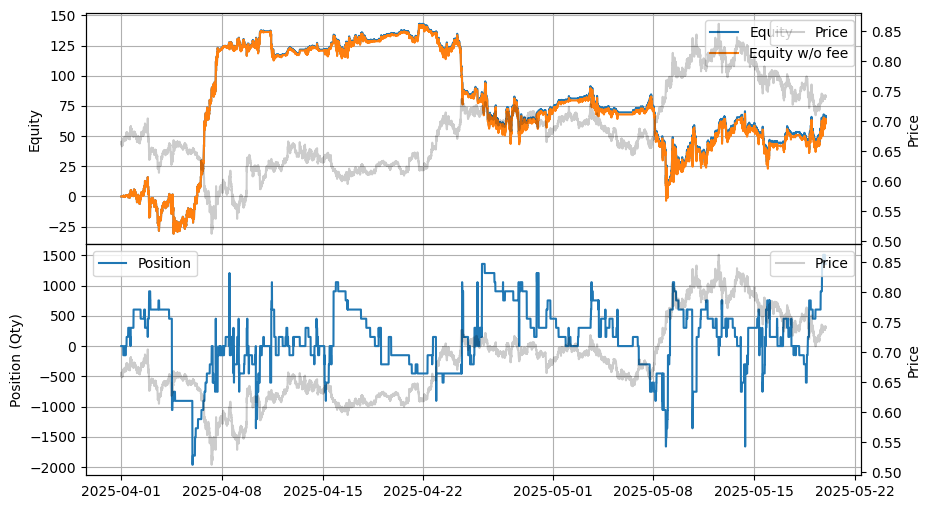

In [18]:
for half_spread in [0.0005, 0.001, 0.0015]:
    data = np.load('bybit_stats/gridtrading_ADAUSDT_{}.npz'.format(half_spread))['0']
    stats = (
        LinearAssetRecord(data)
            .resample('5m')
            .stats()
    )
    stats.plot()

Regarding applying the same parameter set to the multiple pairs in generalized way, you need more generalized model about the volatility and the order flow such like you've seen in the GLFT example. Also, you can see volatility regime change over time-horizon affecting the performance in April in the plot. We will provide the example another emprical approach other than the GLFT example, as a simplified version using non-parametric approach.